## 10 - Seafloor Grids

An adaptation of [agegrid-01](https://github.com/siwill22/agegrid-0.1) written by Simon Williams, Nicky Wright and John Cannon for gridding general z-values onto seafloor basin points using GPlately.

### Define a rotation model, topology features and continents  

In [1]:
import gplately

import numpy as np
import pygplates
import glob, os
import matplotlib.pyplot as plt
import matplotlib.axes as axs
import cartopy.crs as ccrs

gdownload = gplately.download.DataServer("Muller2019")
rotation_model, topology_features, static_polygons = gdownload.get_plate_reconstruction_files()
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

time = 0
continents = "./NotebookFiles/Global_EarthByte_GeeK07_COB_Terranes_2019_v2.gpml"
gplot = gplately.plot.PlotTopologies(model, time, continent_filename=continents)

Checking whether the requested files need to be updated...
Requested files are up-to-date!


### The SeafloorGrid object
Call the SeafloorGrid object - change the `save_directory` to the desired save directory.

In [2]:
seafloorgrid = gplately.oceans.SeafloorGrid(
    model, 
    gplot, 
    max_time = 410.,
    min_time = 400.,
    ridge_time_step = 1.,
    ridge_sampling = 0.5,
    resX = 2000, # resolution of regular grid to interpolate seafloor points onto
    resY = 1000,
    save_directory = "./NotebookFiles/Notebook9", # continent masks, initial ocean seed points, and gridding input files are kept here
    file_collection = gdownload.file_collection, # A string to help name files according to a plate model "Muller2019"
    refinement_levels = 6, # For the initial ocean points - a Stripy icosahedral grid
    initial_ocean_mean_spreading_rate = 50., # To use for the simplistic proximity to MOR spreading rate code
    resume_from_checkpoints = True,
    zval_names = ['SPREADING_RATE']
)

### Preparing for gridding
`seafloorgrid.reconstruct_by_topologies()` prepares all ocean basin points and their z-values for gridding.

At `max_time`, an initial ocean seed point icosahedral mesh fills the ocean basin. Each point is allocated a z-value, and this is stored in an .npz data frame at `max_time`. A netCDF4 continent mask is also produced at `max_time`. 

Then, at each successive timestep, new points emerge from spreading ridges, and they are allocated their own z-values. The workflow recursively outputs:

* 1 netCDF4 continent mask
* 1 GPMLZ file with point features emerging at spreading ridges (resolved according to the specified `ridge_sampling`)
* 1 .npz data frame for point feature z-values

for each time up to `min_time`. *If this preparation stage in `seafloorgrid.reconstruct_by_topologies()` is interrupted between `max_time` to `min_time`, you can rerun the cell. The workflow will pick up from where it left off by default as long as the `resume_from_checkpoints` parameter is passed as `True`, and the auxiliary files that have been saved before interruption have not been erased.*

To overwrite all files in `save_directory` (restart the preparation at `max_time`), pass `resume_from_checkpoints` as `False`.

### Reconstruct by topologies
Once gridding preparation is complete, the `ReconstructByTopologies` object (written by Simon Williams, Nicky Wright, and John Cannon) in GPlately's `reconstruct` is automatically run. `ReconstructByTopologies` (RBT) identifies active points on the ocean basin per timestep. It works as follows:

If an ocean point on one plate ID transitions into another rigid plate ID at the next timestep, RBT calculates the point's velocity difference between both plates. The point **may** have subducted/collided with a continent at this boundary if this velocity difference is higher than a set velocity threshold. To ascertain whether the point should indeed be deactivated, a second test is conducted: RBT checks the previous time position of the point and calculates this point’s proximity to the boundary of the plate ID polygon it is approaching. If this distance is higher than a set distance threshold, then the point is far enough away from the boundary that it cannot be subducted or consumed by it and hence the point is still active. Else, it is deactivated/deleted.

Once all active points and their z-values are identified, they are written to the gridding input file (.npz) for that timestep.

In [3]:
import time
start = time.time()
seafloorgrid.reconstruct_by_topologies()
end = time.time()
print(end - start)

Preparing all initial files...
Finished building initial_ocean_seed_points!
Finished building a continental mask at 410.0 Ma!
Finished building a continental mask at 409.0 Ma!
Finished building a continental mask at 408.0 Ma!
Finished building a continental mask at 407.0 Ma!
Finished building a continental mask at 406.0 Ma!
Finished building a continental mask at 405.0 Ma!
Finished building a continental mask at 404.0 Ma!
Finished building a continental mask at 403.0 Ma!
Finished building a continental mask at 402.0 Ma!
Finished building a continental mask at 401.0 Ma!
Finished building a continental mask at 400.0 Ma!
Finished building MOR seedpoints at 410.0 Ma!
Finished building MOR seedpoints at 409.0 Ma!
Finished building MOR seedpoints at 408.0 Ma!
Finished building MOR seedpoints at 407.0 Ma!
Finished building MOR seedpoints at 406.0 Ma!
Finished building MOR seedpoints at 405.0 Ma!
Finished building MOR seedpoints at 404.0 Ma!
Finished building MOR seedpoints at 403.0 Ma!
Finish

### netCDF gridding
Calling `seafloorgrid.lat_lon_z_to_netCDF` grids one set of z-data per latitude-longitude pair from each timestep's gridding input file (produced in `seafloorgrid.reconstruct_by_topologies()`). Grids are in netCDF format.

The desired z-data to grid is identified using a `zval_name`. 
For example, seafloor age grids can be produced using `SEAFLOOR_AGE`, and spreading rate grids are `SPREADING_RATE`. 

In [4]:
seafloorgrid.lat_lon_z_to_netCDF("SEAFLOOR_AGE", time_arr=seafloorgrid.time_array)

netCDF grid for 410.0 Ma complete!
netCDF grid for 409.0 Ma complete!
netCDF grid for 408.0 Ma complete!
netCDF grid for 407.0 Ma complete!
netCDF grid for 406.0 Ma complete!
netCDF grid for 405.0 Ma complete!
netCDF grid for 404.0 Ma complete!
netCDF grid for 403.0 Ma complete!
netCDF grid for 402.0 Ma complete!
netCDF grid for 401.0 Ma complete!
netCDF grid for 400.0 Ma complete!


### Plotting a sample output

Read one netCDF grid using GPlately's `Raster` object from `grids`, and plot it using the `PlotTopologies` object.

In [5]:
time = 400.0 # Ma
grid_filename = "{}/{}_SEAFLOOR_AGE_grid_{}Ma.nc".format(seafloorgrid.save_directory, seafloorgrid.file_collection, time)
age_grid = gplately.grids.Raster(filename=grid_filename)

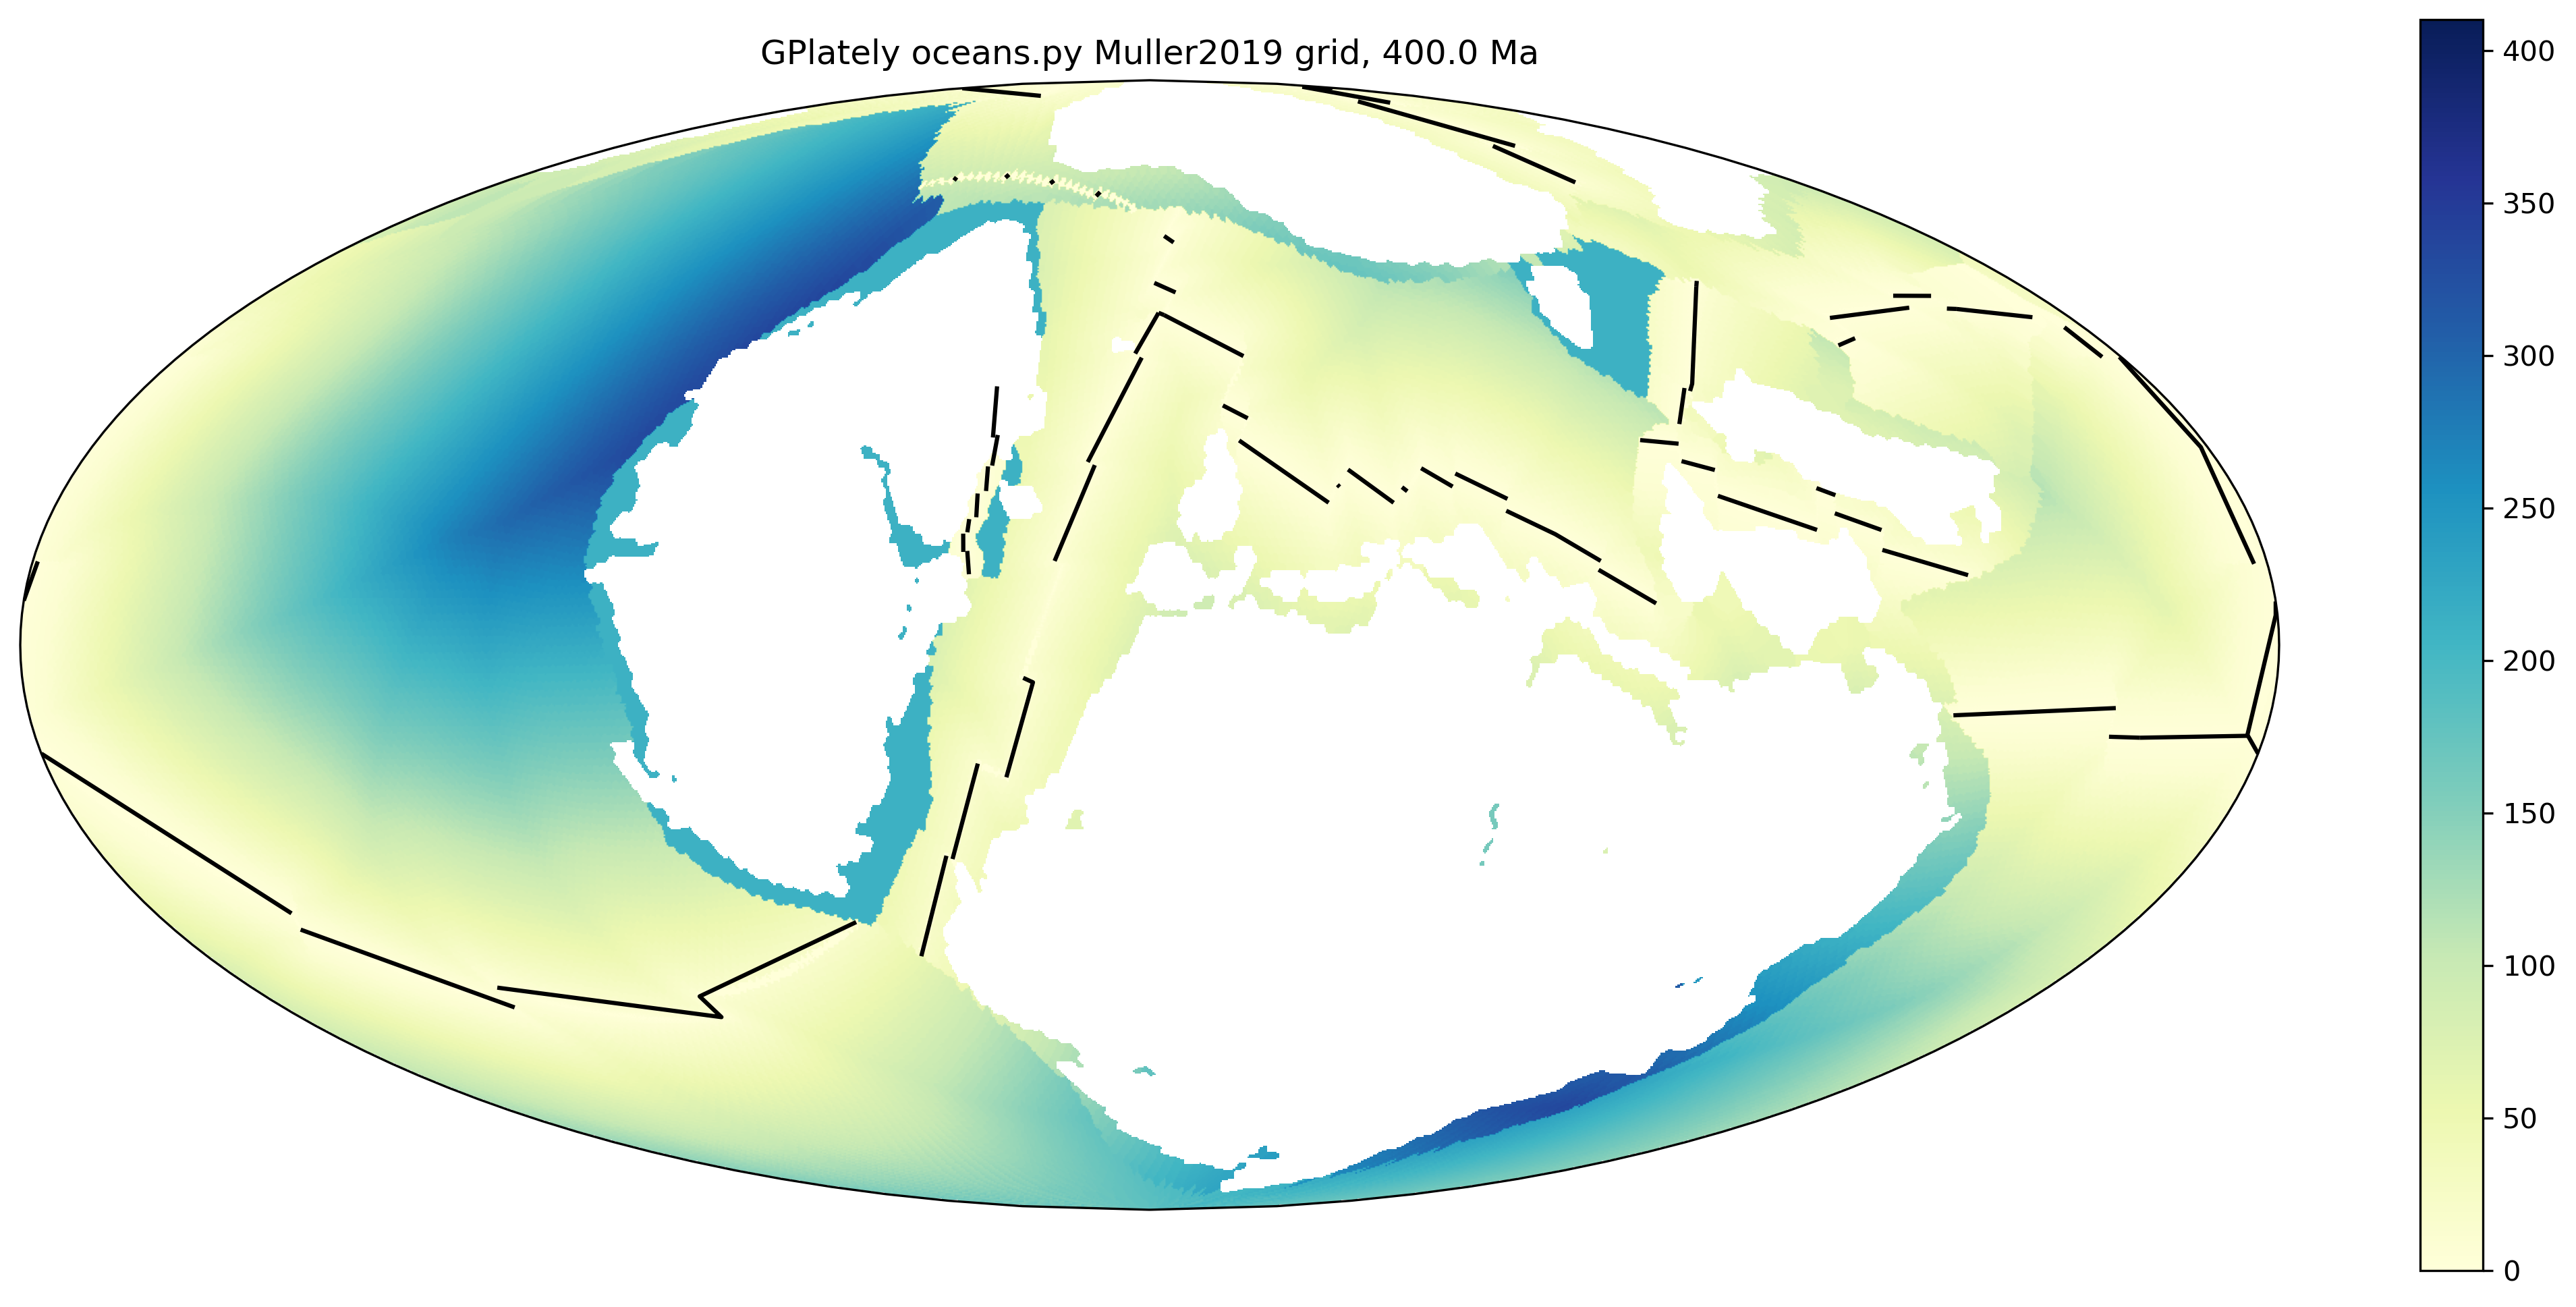

In [6]:
fig = plt.figure(figsize=(18,18), dpi=300, linewidth=2)
ax5 = fig.add_subplot(212, projection=ccrs.Mollweide(central_longitude=20))

gplot.time = time
plt.title("GPlately oceans.py {} grid, {} Ma".format(seafloorgrid.file_collection, time))
im2 = gplot.plot_grid(
    ax5, 
    age_grid.data, 
    cmap="YlGnBu",
    vmin = 0, 
    vmax =410,
)
gplot.plot_ridges(ax5)
plt.colorbar(im2)